In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from lidar_integrating_space_time_std import Lidar_space_time2 as lidar_integ_std #maybe not used
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR3 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time

In [2]:
#####Load MRR Data
path_MRR = "I:/PHD/Lidar/Inversion_V2/MRR_Data/"
Ze = np.loadtxt(path_MRR + "Ze_10min.txt")
times_MRR = np.loadtxt(path_MRR + "times.txt")
Height_MRR = np.loadtxt(path_MRR + "Height.txt")

Zem = np.ma.masked_where(Ze == -9999, Ze)

#####Load font format

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
        
pylab.rc('font', **font)      

#####Color Parameters
cmap = pylab.cm.jet
bounds = np.linspace(1,3,4)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
bounds2 = np.linspace(0,12,14)
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap.N)

cmap2 = pylab.cm.get_cmap(cmap.name,8)

##### output Temporal RESolution
TRES = 5 #min. 

##### output Temporal resolution
VRES = 3 #bins, 1bin = 3.8m # try only 1,2,3,6 bins


In [3]:
def BG_corr2(P,r,year,month,day, rcf0 = 9, pol = 'parallel',color = "blue"):
    
    import sys, os
    sys.path.append("lib")
    from Sigma_mol import sigma_mol
    from scipy.interpolate import interp1d      
    import time
    from calendar import timegm
    import pylab
    import numpy as np
    from scipy import stats

    utc_time = time.strptime(str(year)+"-"+str(month).zfill(2)+"-"+str(day).zfill(2)+" 00:00:00", "%Y-%m-%d %H:%M:%S")
    epoch_time = timegm(utc_time)  
    
    month2 = time.gmtime(epoch_time+3600*24)[1]
    day2 = time.gmtime(epoch_time+3600*24)[2]
    
    [sigma1, h1] = sigma_mol(year = year, month = month, day = day)
    [sigma2, h2] = sigma_mol(year = year, month = month2, day = day2)
    
    print np.size(sigma1)
    
    if (np.size(sigma1) > 1) & (np.size(sigma2) > 1):
        mat = np.ma.masked_where(np.array([sigma1.filled(-9999),sigma2.filled(-9999)]) == -9999,np.array([sigma1.filled(-9999),sigma2.filled(-9999)]))
        sigma = np.nanmean(mat,axis = 0)[10:]
        h = h1[10:]

    if (np.size(sigma1) == 1) & (np.size(sigma2) > 1):
        sigma = sigma2[10:]
        h = h2[10:]

    if (np.size(sigma1) > 1) & (np.size(sigma2) == 1):
        sigma = sigma1[10:]
        h = h1[10:]
        
    rcf = np.squeeze(np.where(h < rcf0))[-1] 
    rcf_lidar = np.squeeze(np.where(r >= rcf0))[0]
    
    Tm = np.exp((-2*np.cumsum(sigma[rcf:])*(h[1]-h[0])))
    Tm_rcf = np.exp((-2*np.cumsum(sigma[0:rcf])*(h[1]-h[0])))
    Tm_full = np.exp((-2*np.cumsum(sigma)*(h[1]-h[0])))    
    
    if pol == 'parallel':
        beta = 0.996*sigma/((8*np.pi/3)*1.0401)
    if pol == 'perpendicular': 
        beta = 0.00366*sigma/((8*np.pi/3)*1.0401)
        
    f = interp1d(h[rcf:], Tm*beta[rcf:]/(h[rcf:]**2))    
        
    lm = stats.linregress(x = f(r[rcf_lidar:]), y = P[rcf_lidar:])
    
    #pylab.plot(f(r[rcf_lidar:]),P[rcf_lidar:], "o", color = color)
    
    #pylab.plot(np.linspace(np.min(f(r[rcf_lidar:])),np.max(f(r[rcf_lidar:])),3), np.linspace(np.min(f(r[rcf_lidar:])),np.max(f(r[rcf_lidar:])),3)*lm[0]+lm[1], color = color, label = str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2) + " ("+r'$y = $'+str(int(lm[0]))+r'$x$ + ' + str(round(lm[1],2))+", "+r'$r^2 = $'+str(round(lm[2],2))+")")
    
    #print np.mean(P[rcf_lidar:])
    #ax.ticklabel_format(axis = "x", style='scientific',scilimits = (-1,2))
    
    #pylab.legend(frameon = False, loc = "upper left" , fontsize = 18)
    
    return [lm,Tm_full,h,sigma]

In [ ]:
##### output Temporal RESolution
TRES = 10 #min. 

##### output Temporal resolution
VRES = 6 #bins, 1bin = 3.8m # try only 1,2,3,6 bins


for count in range(1000):
    if count > 0: print "Next iteration"
    ##### Dates
    #[ini, end]
    year0 = [2017,2017]
    month0 = [2,12]
    day0 = [1,31]

    ##### Routine
    for year in range(year0[0],year0[1]+1):
        for month in range(month0[0],month0[1]+1):
            for day in range(day0[0],day0[1]+1):

                path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                filename1 = path_in+"Par90/Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename2 = path_in+"Par10/Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename3 = path_in+"Per/Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename4 = path_in+"Nprofiles/Nprofiles_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min"+".dat"

                path_out = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                filename5 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename6 = path_in+"Par10_bc/Par10bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename7 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename8 = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename9 = path_in+"SNR/SNR_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename10 = path_in+"SNR/SNR_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename11 = path_in+"Background/BG_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename12 = path_in+"Background/BG_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename13 = path_in+"Background/BG_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                
                if os.path.isfile(filename13):
                    #print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data ready"
                    continue
                
                if os.path.isfile(filename1):
                    Par90 = np.loadtxt(filename1)
                    Par10 = np.loadtxt(filename2)
                    Per   = np.loadtxt(filename3)
                    r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
                    npt = np.loadtxt(filename4)

                    BG1 = np.zeros(shape = np.shape(Par90)[0])
                    BG10 = np.zeros(shape = np.shape(Par90)[0])
                    BG2 = np.zeros(shape = np.shape(Par90)[0])

                    print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"
                else:
                    #print "File not found"
                    continue

                Par_bc = np.zeros(shape = np.shape(Par90))
                Par10_bc = np.zeros(shape = np.shape(Par90))
                Per_bc = np.zeros(shape = np.shape(Per))
                SNR_par = np.zeros(shape = np.shape(Per))
                SNR_par10 = np.zeros(shape = np.shape(Per))
                SNR_per = np.zeros(shape = np.shape(Per))

                for i in range(np.shape(Par90)[0]):
                    try:
                        BG1[i] = BG_corr(Par90[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG10[i] = BG_corr(Par10[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG2[i] = BG_corr(Per[i,:],r[:],year, month, day,rcf0 = 9,pol = 'perpendicular')[0][1]  
                    except:
                        continue
                        
                    if BG1[i] < 0: BG1[i] = 0
                    if BG10[i] < 0: BG10[i] = 0
                    if BG2[i] < 0: BG2[i] = 0

                    if BG1[i] > np.nanmean(Par90[i,-50:]): BG1[i] = np.nanmean(Par90[i,-50:])
                    if BG10[i] > np.nanmean(Par10[i,-50:]): BG10[i] = np.nanmean(Par10[i,-50:])
                    if BG2[i] > np.nanmean(Per[i,-50:]): BG2[i] = np.nanmean(Per[i,-50:])

                    Par_bc[i,:] = Par90[i,:]-BG1[i]
                    Par10_bc[i,:] = Par10[i,:]-BG10[i]
                    Per_bc[i,:] = Per[i,:]-BG2[i]  

                    SNR_par[i,:] = (Par_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par_bc[i,:]+2*(BG1[i]))**0.5
                    SNR_par10[i,:] = (Par10_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par10_bc[i,:]+2*(BG10[i]))**0.5
                    SNR_per[i,:] = (Per_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Per_bc[i,:]+2*(BG2[i]))**0.5

                    Par_bc[i,:] = (Par_bc[i,:])*r**2
                    Par10_bc[i,:] = (Par10_bc[i,:])*r**2
                    Per_bc[i,:] = (Per_bc[i,:])*r**2  

                np.savetxt(filename5,Par_bc)
                np.savetxt(filename6,Par10_bc)
                np.savetxt(filename7,Per_bc)

                np.savetxt(filename8,SNR_par)
                np.savetxt(filename9,SNR_par10)
                np.savetxt(filename10,SNR_per)

                np.savetxt(filename11,BG1)
                np.savetxt(filename12,BG10)
                np.savetxt(filename13,BG2)
    print "waiting 15 minutes..."
    time.sleep(15*60)
    print "iteration = ", count
    #month00 = month

20170915 Data loaded


C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:88: RuntimeWarning: invalid value encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:87: RuntimeWarning: invalid value encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:89: RuntimeWarning: invalid value encountered in divide


20170916 Data loaded
20170917 Data loaded
waiting 15 minutes...
iteration =  0
Next iteration
20170918 Data loaded
20170919 Data loaded
20170920 Data loaded
20170921 Data loaded
20170922 Data loaded
20170923 Data loaded
20170924 Data loaded
waiting 15 minutes...
iteration =  1
Next iteration
20170925 Data loaded
20170926 Data loaded
20170927 Data loaded
20170928 Data loaded
20170929 Data loaded
20170930 Data loaded
20171001 Data loaded
20171002 Data loaded
waiting 15 minutes...


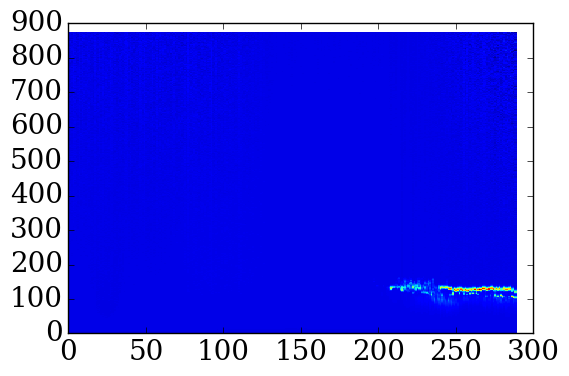

In [216]:
pylab.pcolor(np.transpose(Par10_bc))
pylab.show()

In [197]:
np.shape(npt),np.shape(SNR_par)

((289L,), (289L, 874L))

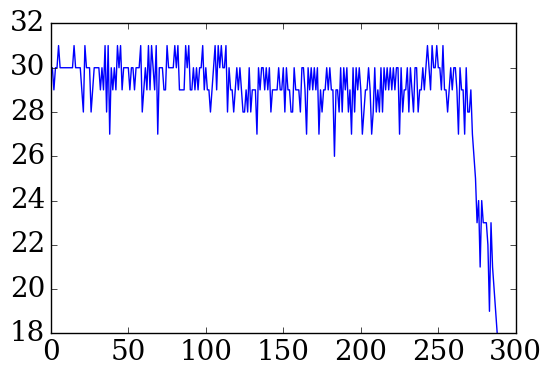

(array([], dtype=int64),)

In [200]:
pylab.plot(npt)
pylab.show()
np.where(npt == 0)

#49487.92592593,   33084.83333333,   24145.90740741,
#         19702.03703704,   18088.27777778,   18037.42592593,
#         18421.7037037 ,   18902.53703704,   19288.85185185,
#         19469.2037037 ,   19583.98148148,   19614.38888889,
#         19550.55555556,   19385.44444444,   19281.74074074,
#         19173.81481481,   190

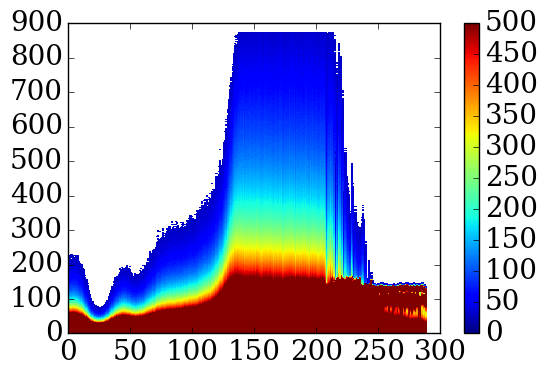

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in log10


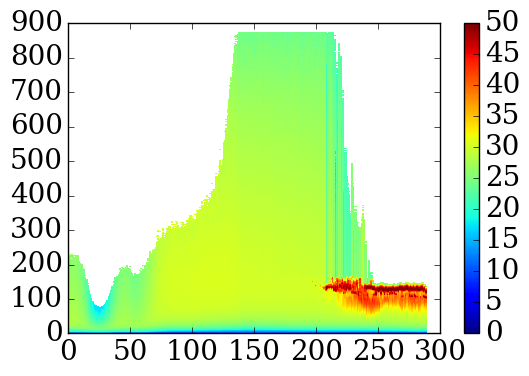

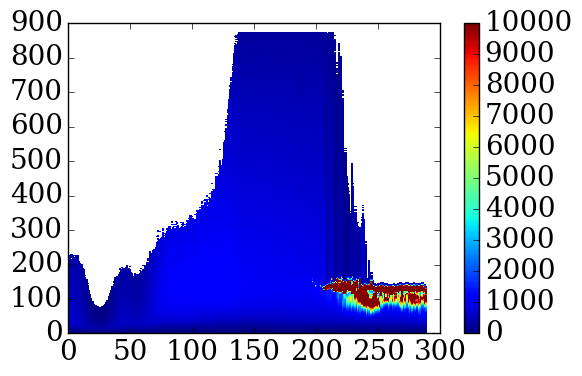

In [201]:
SNR_parb = np.ma.masked_where(SNR_par<30,SNR_par)

pylab.pcolor(np.transpose(SNR_parb), vmin = 0, vmax = 500)
pylab.colorbar()
pylab.show()

SNR_par_2b = np.ma.masked_where(SNR_par_2<30,Par_bc)

pylab.pcolor(np.transpose(10*np.log10(SNR_par_2b)), vmin = 0, vmax = 50)
pylab.colorbar()
pylab.show()

pylab.pcolor(np.transpose(SNR_par_2b), vmin = 0, vmax = 10000)
pylab.colorbar()
pylab.show()

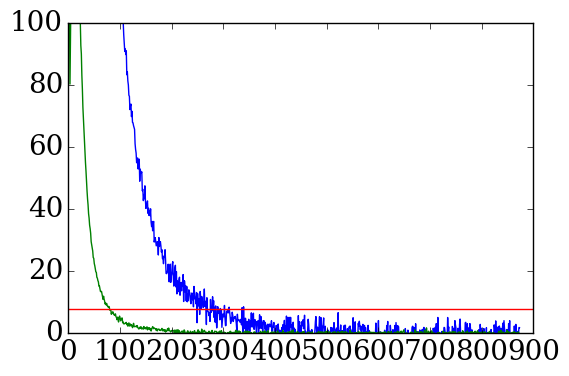

In [206]:

pylab.plot(SNR_par[50,:])
#pylab.plot(SNR_par[150,:])
#pylab.plot(SNR_par[275,:])

pylab.plot(SNR_par10_2[50,:])
#pylab.plot(SNR_per_2[50,:])

pylab.plot([0,900],[8,8])
pylab.axis([0,900,0,100])
pylab.show()

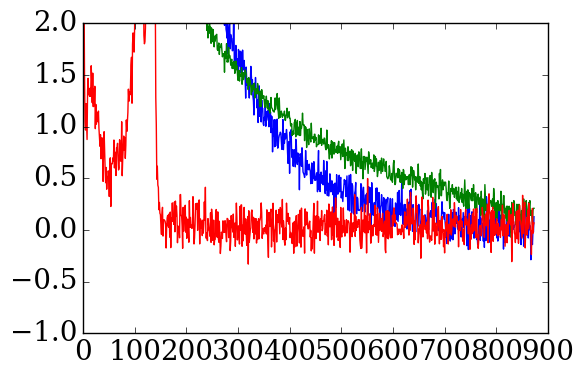

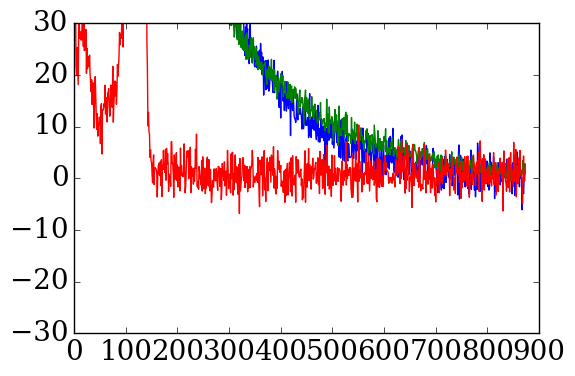

In [189]:
pylab.plot(SNR_par[100,:])
pylab.plot(SNR_par10[150,:])
pylab.plot(SNR_per[275,:])
pylab.axis([0,900,-1,2])
pylab.show()

pylab.plot(SNR_par_2[100,:])
pylab.plot(SNR_par10_2[175,:])
pylab.plot(SNR_per_2[275,:])
pylab.axis([0,900,-30,30])
pylab.show()